In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from classifier import MLPBinary
import utils

In [ ]:
# resizing of the data created with monte carlo

lt, ut, t_step = 1.0, 3.2, 0.003

#for L in [10, 15, 20]:
 #   utils.resize_data(L, lt, ut)
    
utils.resize_data_test(10)

In [2]:
L = 10
T_CRIT = 2.2691853 # k_b * T_C / J  with k_b=1, J = interaction constant
data = np.load(f"data/{L}_test_tanti.npy").reshape(-1, 100)
temps = np.load(f"data/{L}_temp_tanti.npy").reshape(-1,)
n = data.shape[0]
# target value
t = (temps > T_CRIT).astype(int)

# DATA Shuffling
rng = np.random.default_rng()
indices = np.arange(data.shape[0])
rng.shuffle(indices)

data = data[indices]
t = t[indices]
temps = temps[indices]

# splitting data in 80% training, 20% validation
a = int(0.8*n)
data_train = data[:a]
data_val = data[a:]

t_train = t[:a]
t_val = t[a:]

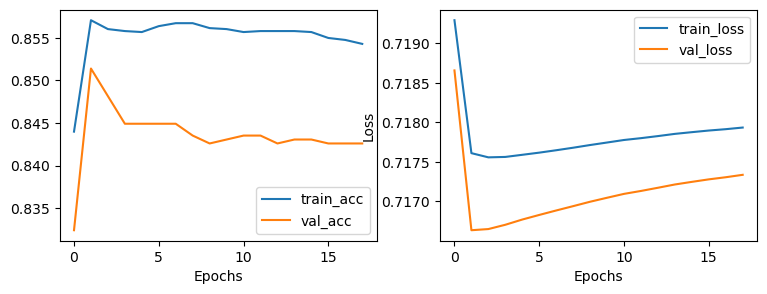

In [19]:
# CLASSIFIER TRAINING
clf = MLPBinary(dim_hidden=100, tolerance=1e-4, activation='relu', lr=0.01, batch_size=200, momentum=0.8, solver='sgd', alpha=0.2, power_t=0.5, n_epochs_no_update=15)
clf.fit(data_train, t_train, X_val=data_val, t_val=t_val)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
E = len(clf.train_acc) 
ax1.plot(np.arange(E), clf.train_acc)
ax1.plot(np.arange(E), clf.val_acc)
ax1.legend(["train_acc", "val_acc"])

ax2.plot(np.arange(E), clf.train_loss)
ax2.plot(np.arange(E), clf.val_loss)
ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])

In [6]:
clf.score(data_train, t_train)

0.5029465663580247

In [5]:
b = clf.weights2.flatten()
b @ b.T

6.746476036426959

In [35]:
for i in range(10):
    print(clf.score(data_test[i], t_test[4]))

0.875
0.9583333333333334
0.875
0.9166666666666666
0.875
0.9166666666666666
0.9166666666666666
0.9583333333333334
0.7916666666666666
0.875


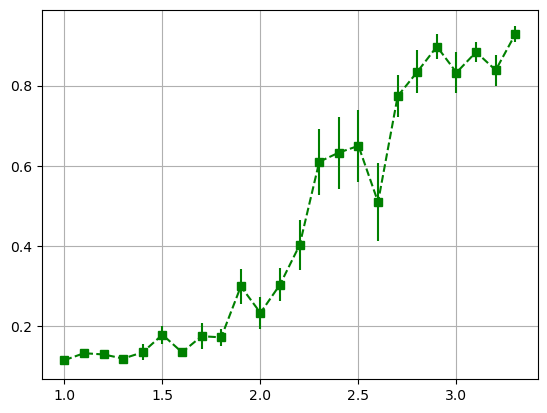

In [33]:
# loading data for testing
temp_test = np.load(f"./data/{L}_test_temp.npy")
data_test = np.load(f"./data/{L}_test.npy")


# sort data into ascending order according to temperatures
# potrei metterlo in utils

index = np.argsort(temp_test, axis=1)
temp_test = np.sort(temp_test, axis=1)
index_expanded = index[..., np.newaxis]
data_test = np.take_along_axis(data_test, index_expanded, axis=1)

t_test = (temp_test > T_CRIT).astype(int)

# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_probabilities(flattened).reshape(10, 24, 1)
errors = y[:,:,0].std(axis=0) / np.sqrt(10)
plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), errors, fmt='s--g')
plt.grid(True)


## SKLEARN

c:\Users\CrisMattGiov\miniconda3\envs\in3050\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


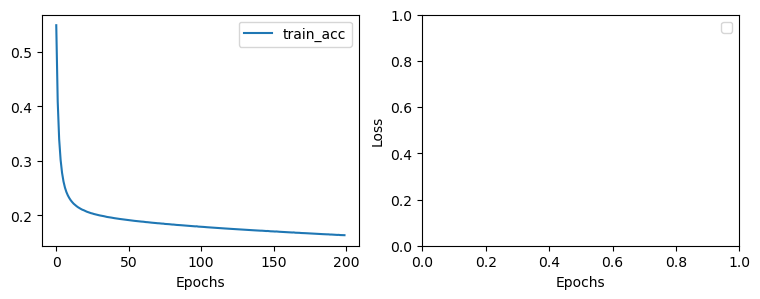

In [13]:
# training with sklearn

# using skleanr
clf = MLPClassifier(activation='relu', solver='sgd',alpha=0, momentum=0.9, nesterovs_momentum=False,  verbose=False)
clf.fit(data_train, t_train)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))


E = len(clf.loss_curve_) 
ax1.plot(np.arange(E), clf.loss_curve_)

ax1.legend(["train_acc", "val_acc"])

ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])


In [25]:
a

array([-0.90546457, -0.1378373 , -1.47188649, -1.51487154, -0.81432088,
        0.75944594, -1.00058496, -1.83906728, -1.16050341, -1.66239811,
       -1.0132432 , -1.21779897, -0.67934824, -0.62183716,  0.0482177 ,
        0.00259813, -1.47605543, -1.37647152,  1.61163821, -0.38320568,
       -1.30527209, -1.11421507, -0.27384306, -0.64283125, -1.11085776,
        0.00436534, -0.79008907, -1.1211336 , -1.27667068, -0.41782946,
       -0.74590028, -1.30770723, -1.76286262, -1.5023387 , -1.67671285,
       -0.77245605,  0.0373648 , -0.4840092 , -1.08800731,  1.98212379,
       -0.49954154, -1.26749094, -0.59376661, -1.37821492, -1.72141089,
       -2.08198861, -0.49349735, -1.43687909,  0.35798475, -1.62859099,
       -0.35327564, -1.50329627, -0.1085081 , -0.71451925, -1.13807815,
       -0.6048107 , -1.49689115, -0.21273558, -0.71890367, -1.12653529,
       -1.20709897,  1.35686846, -1.5212886 , -0.17229077, -1.32211097,
       -1.53420632, -1.12454045, -0.6479847 , -0.95453862,  0.78

In [10]:
a = clf.coefs_[1].flatten()
a @ a.T

92.06137197203769

In [14]:
min(clf.loss_curve_)

0.1634691189926141

In [8]:
clf.score(data_test[4], t_test[0])

1.0

In [9]:
# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_proba(flattened).reshape(10, 24, 2)

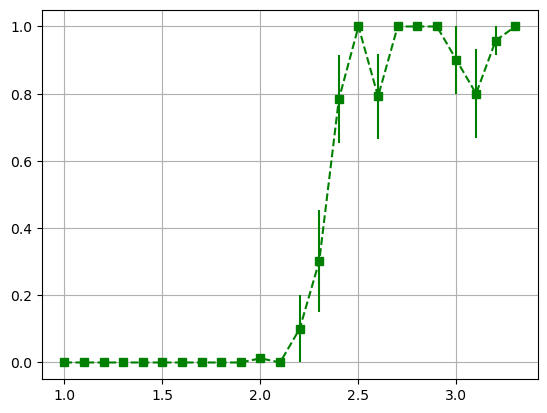

In [15]:
train_size = 10
errors = y[:,:,0].std(axis=0, ddof=1) / np.sqrt(train_size)  # std/(N-1)
plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), errors, fmt='s--g')
plt.grid(True)

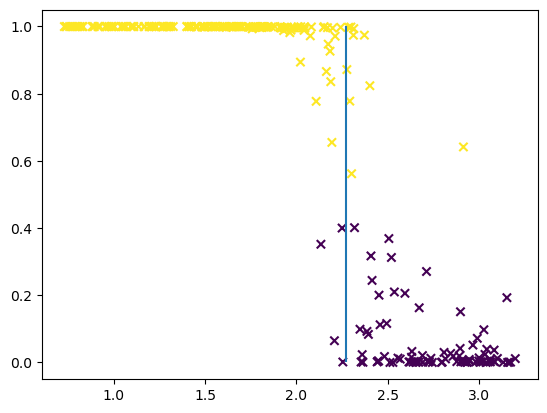

In [69]:
out = clf.predict_proba(data_val)
plt.scatter(temps[a:], out[:,1], marker='x', c=clf.predict(data_val) )
plt.vlines(T_CRIT, 0, 1)